In [1]:
import cv2
import os
import shutil
import torch,torchvision
import math
import pandas
import natsort
import torchvision.transforms as transforms
from torchvision import datasets
import torch.optim as optim
import numpy as np
from PIL import Image, ImageFilter
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from sklearn.preprocessing import label_binarize
from itertools import cycle
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path = "/content/drive/MyDrive/BinarySplit1"

In [ ]:
def count_images_in_folder(folder_path):
    image_extensions = ['.jpg', '.jpeg', '.png']
    files = os.listdir(folder_path)
    num_images = sum(1 for file in files if os.path.isfile(os.path.join(folder_path, file)) and
                     any(file.lower().endswith(ext) for ext in image_extensions))
folder_path1 = 'BinarySplit/LessThan28'
folder_path2 = 'BinarySplit/GreaterThan29'

In [ ]:
def load_data(path, test_split, val_split, batch_size, input_size):
    modifyDict={'src':transforms.Compose([transforms.RandomHorizontalFlip(),
                                              transforms.Resize((224,224)),
                      transforms.RandomVerticalFlip(),
                      transforms.RandomRotation(15),
                      transforms.ToTensor(),
                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])}
    org_data = datasets.ImageFolder(root=path,transform =modifyDict['src'])
    testSubsetSize=int(len(org_data)*test_split)
    valDataSize=int(len(org_data)*val_split)
    trainSubsetSize=len(org_data)-valDataSize-testSubsetSize
    train_dataset,test_dataset,val_dataset = torch.utils.data.random_split(org_data,[trainSubsetSize,testSubsetSize,valDataSize])
    trainSetDataLoader = DataLoader(train_dataset,batch_size,shuffle=True)
    testSetDataLoader = DataLoader(test_dataset,batch_size,shuffle=False)
    valSetDataLoader = DataLoader(val_dataset,batch_size,shuffle=False)
    return trainSetDataLoader, testSetDataLoader, valSetDataLoader

In [ ]:
train_loader, test_loader, val_loader = load_data(path, test_split=0.1, val_split= 0.1, batch_size=32, input_size=[224, 224])

In [ ]:
model = torchvision.models.mobilenet_v2(pretrained=False, num_classes=2)
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

/home/anmol/anaconda3/envs/comp6721/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/anmol/anaconda3/envs/comp6721/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [ ]:
numb_epochs = 100
training_loss = []
validation_loss = []
validation_accuracy = []
training_accuracy = []
for epoch in range(numb_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        labels = labels.to(device)
        images = images.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    training_loss.append(train_loss)
    training_accuracy.append(train_acc)
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        val_loss = 0.0
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        val_loss /= len(val_loader.dataset)
        val_acc = 100 * correct / total
        validation_loss.append(val_loss)
        validation_accuracy.append(val_acc)
        print(f'Epoch {epoch + 1}/{numb_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%')

Epoch 1/100, Train Loss: 0.7034, Train Accuracy: 57.79%, Validation Loss: 0.0415, Validation Accuracy: 59.79%
Epoch 2/100, Train Loss: 0.6392, Train Accuracy: 63.64%, Validation Loss: 0.0381, Validation Accuracy: 68.10%
Epoch 3/100, Train Loss: 0.5738, Train Accuracy: 70.60%, Validation Loss: 0.0328, Validation Accuracy: 73.61%
Epoch 4/100, Train Loss: 0.5436, Train Accuracy: 72.82%, Validation Loss: 0.0405, Validation Accuracy: 69.10%
Epoch 5/100, Train Loss: 0.5293, Train Accuracy: 73.68%, Validation Loss: 0.0327, Validation Accuracy: 75.76%
Epoch 6/100, Train Loss: 0.5156, Train Accuracy: 74.59%, Validation Loss: 0.0362, Validation Accuracy: 72.21%
Epoch 7/100, Train Loss: 0.5077, Train Accuracy: 75.11%, Validation Loss: 0.0320, Validation Accuracy: 74.46%
Epoch 8/100, Train Loss: 0.5018, Train Accuracy: 75.25%, Validation Loss: 0.0347, Validation Accuracy: 70.56%
Epoch 9/100, Train Loss: 0.5003, Train Accuracy: 75.64%, Validation Loss: 0.0311, Validation Accuracy: 76.11%
Epoch 10/1

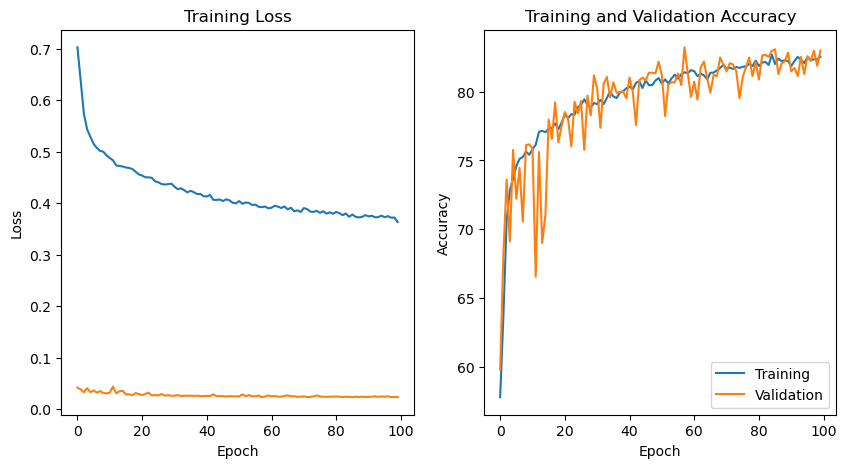

In [ ]:
plt.figure(figsize=(11,6))
plt.subplot(1,2,1)
plt.plot(training_loss,label='Training')
plt.plot(validation_loss, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.subplot(1,2,2)
plt.plot(training_accuracy, label='Training')
plt.plot(validation_accuracy, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

In [ ]:
model.eval()
with torch.no_grad():
    total = 0
    correct = 0
    y_exp = []
    y_pred = []
    for images, labels in test_loader:
        labels = labels.to(device)
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        y_pred.extend(outputs.cpu().numpy())
        y_exp.extend(labels.cpu().numpy())
    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy}')
torch.save(model.state_dict(), '/content/drive/MyDrive/BinarySplit1/UTKFaceMobilenet.pth')

Test Accuracy: 80.72108162243364


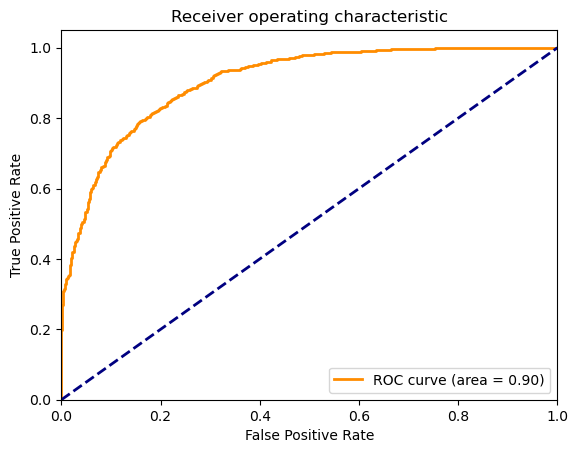

In [ ]:
y_pred = np.array(y_pred)
y_exp = np.array(y_exp)
y_pred = y_pred[:, 1]
y_exp = y_exp.reshape(y_pred.shape)
frp, tpr, thresholds = roc_curve(y_exp, y_pred)
roc_auc = auc(frp, tpr)
plt.figure()
plt.plot(frp, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc="lower right")
plt.title('Receiver operating characteristic')
plt.show()

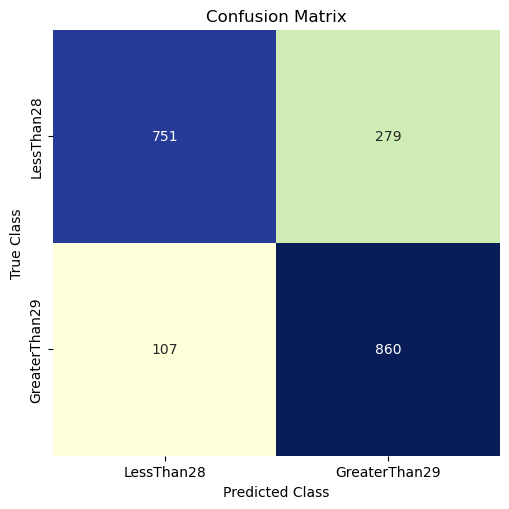

In [ ]:
y_pred = []
y_exp = []
for images, labels in test_loader:
        labels = labels.to(device)
        images = images.to(device)
        y_exp.extend(labels.cpu().numpy())
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        y_pred.extend(predicted.cpu().numpy())
conf_matrix = confusion_matrix(y_exp, y_pred)
class_names = ('LessThan28', 'GreaterThan29')
dataframe = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)
plt.figure(figsize=(6, 6))
sns.heatmap(dataframe, annot=True, cbar=None,cmap="YlGnBu",fmt="d")
plt.title("Confusion Matrix"),
plt.tight_layout()
plt.xlabel("Predicted Class"),
plt.ylabel("True Class")
plt.show()